In [8]:
import cv2
import os
import shutil
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
path2 = "C:/Users/jokub/Desktop/Praktika/dataset (A2) - thumbnail/"
path = "C:/Users/jokub/Desktop/Praktika/dataset (A1) - thumbnail (1.7GB)/"
rootDir = 'C:/Users/jokub/Desktop/Praktika/'
dataFolder = rootDir+"data/"
tempFolder = rootDir+"temp/"
testFolder = rootDir+'test/'
testFolder2 = rootDir+'test2/'
imageExtensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

In [10]:
try:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if len(physical_devices) == 0:
        print("No GPUs available.")
    else:
        print("Available GPU devices:", [d.name for d in physical_devices])

    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
except:
    print("Device is already chosen")

Available GPU devices: ['/physical_device:GPU:0']


In [11]:
def readImagesFolder(path):
    images = []
    files = os.listdir(path)
    files = [file for file in files if os.path.splitext(file)[-1].lower() in imageExtensions]
    print(files)

    for file in files:
        images.append(readImage(path+file))
    return images

def readImage(file):
    return cv2.imread(file)

def showImages(images):
    for image in images:
        cv2.imshow('Image', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

def splitImages(path):
    files = os.listdir(path)
    files = [file for file in files if os.path.splitext(file)[1].lower() in imageExtensions]
    print(files)

    for file in files:
        image = readImage(path+file)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
        maskInv = cv2.bitwise_not(mask)
        contours, _ = cv2.findContours(maskInv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        outputDir = dataFolder+file
        os.makedirs(outputDir, exist_ok=True)

        for i, contour in enumerate(contours):
            x, y, w, h = cv2.boundingRect(contour)
            individualImage = image[y:y+h, x:x+w]
            sizeKb = len(cv2.imencode('.jpg', individualImage)[1]) / 1024
            if sizeKb < 1:
                continue
            outputFilename = os.path.join(outputDir, f'image_{i+1}.jpg')
            cv2.imwrite(outputFilename, individualImage)
            print(f'Saved {outputFilename}')

def deleteEmptyFolders(rootDir):
    for dirpath, dirnames, _ in os.walk(rootDir, topdown=False):
        for dirname in dirnames:
            try:
                os.rmdir(os.path.join(dirpath, dirname))
            except:
                print("dir: "+os.path.join(dirpath, dirname)+" isn't empty")


def mergeFoldersWithSameEnding(path):
    folders = {}
    for dirpath, _, filenames in os.walk(path):
        for filename in filenames:

            folderName = os.path.basename(dirpath)
            parts = folderName.split("#")
            newFolderName = parts[-1]

            if newFolderName in folders:
                index = folders[newFolderName]
                shutil.move(os.path.join(dirpath, filename), os.path.join(path, newFolderName, f"{index}_{filename}"))
            else:
                folders[newFolderName] = len(folders) + 1
                newFolderPath = os.path.join(path, newFolderName)
                os.makedirs(newFolderPath, exist_ok=True)
                shutil.move(os.path.join(dirpath, filename), os.path.join(newFolderPath, f"{len(folders)}_{filename}"))
                
    deleteEmptyFolders(path)

def countFilesInFolders(rootDir):
    folderCounts = {}

    for dirpath, dirnames, filenames in os.walk(rootDir):
        folderName = os.path.basename(dirpath)
        fileCount = len(filenames)
        folderCounts[folderName] = fileCount

    return folderCounts

def countFilesInDirectory(data):
    folderCounts = countFilesInFolders(data)
    for folder, count in folderCounts.items():
        print(f"Folder: {folder}, Number of Files: {count}")
    return folderCounts

def getMinClassItemCount(path,size):
    
    folderCounts = countFilesInDirectory(path)
    new_folderCounts = {folder: count for folder, count in folderCounts.items() if count >= size}

    print("Original folder counts:", folderCounts.values())
    print(f"New folder counts (values no less than {size}):", new_folderCounts.values())
    return min(new_folderCounts.values())    

def createDatasetFromSampleSize(path,targetPath,size):
    classFolders = os.listdir(path)
    sampleSize = getMinClassItemCount(path,size)

    if not os.path.exists(targetPath):
        os.makedirs(targetPath)

    for classFolder in classFolders:
        sourceClassPath = os.path.join(path, classFolder)
        destinationClassPath = os.path.join(targetPath, classFolder)
        
        if not os.path.exists(destinationClassPath):
            os.makedirs(destinationClassPath)

        files = os.listdir(sourceClassPath)

        if len(files) >= sampleSize:
            random.shuffle(files)
            for file in files[:sampleSize]:
                sourceFilePath = os.path.join(sourceClassPath, file)
                destinationFilePath = os.path.join(destinationClassPath, file)
                shutil.copyfile(sourceFilePath, destinationFilePath)


    deleteEmptyFolders(targetPath)

def predSingleImage(singleImagePath, trainDs, model):
    singleImage = image.load_img(singleImagePath, target_size=(224, 224))
    singleImageArray = image.img_to_array(singleImage)
    singleImageArray = np.expand_dims(singleImageArray, axis=0)
    singleImageArray = preprocess_input(singleImageArray)

    predictedProbabilities = model.predict(singleImageArray)

    predictedClassIndex = np.argmax(predictedProbabilities)

    classLabels = list(trainDs.class_indices.keys())
    predictedClassLabel = classLabels[predictedClassIndex]
    plt.imshow(singleImage)
    plt.axis('off')
    plt.show()

    print("Predicted class:", predictedClassLabel)
    print("Class probabilities:", predictedProbabilities)

In [12]:
images = readImagesFolder(path)
splitImages(path)
mergeFoldersWithSameEnding(dataFolder)

In [13]:
createDatasetFromSampleSize(dataFolder,tempFolder,128)

In [14]:
imgHeight, imgWidth = 224, 224
batchSize = 20

train_folder = tempFolder
val_folder = testFolder

dataGen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

trainDs = dataGen.flow_from_directory(
    train_folder,
    target_size=(imgHeight, imgWidth),
    batch_size=batchSize,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valDs = dataGen.flow_from_directory(
    val_folder,
    target_size=(imgHeight, imgWidth),
    batch_size=batchSize,
    class_mode='categorical',
    shuffle=False
)

mName = f"{trainDs.num_classes}cat{batchSize}batch"


Found 1420 images belonging to 5 classes.
Found 355 images belonging to 5 classes.


In [15]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(imgHeight, imgWidth, 3))
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(trainDs.num_classes, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    trainDs,
    steps_per_epoch=trainDs.samples // batchSize,
    epochs=100,
    validation_data=valDs,
    validation_steps=valDs.samples // batchSize,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)
model.save(mName+'.h5')

In [16]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [17]:
model = tf.keras.models.load_model('84perc_best_so_far.h5')

In [18]:
model.evaluate(valDs, return_dict=True)

355/355 [==============================] - 5s 7ms/step - loss: 0.3875 - accuracy: 0.8563


{'loss': 0.38748064637184143, 'accuracy': 0.8563380241394043}

355/355 [==============================] - 3s 7ms/step


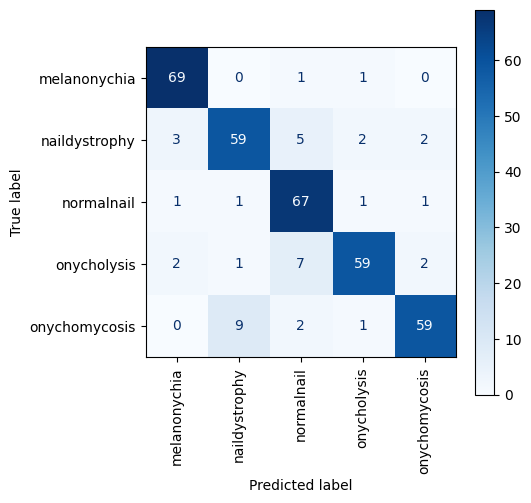

In [19]:
yTrue = valDs.classes
yPredProb = model.predict(valDs)
yPred = np.argmax(yPredProb, axis=-1)
classNames = valDs.class_indices.keys()
confusionMatrix = confusion_matrix(yTrue, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=classNames)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()


In [20]:
accuracy = np.trace(confusionMatrix) / np.sum(confusionMatrix)
print("Accuracy:", accuracy)

Accuracy: 0.8816901408450705


In [21]:
trainDs.class_indices

{'melanonychia': 0,
 'naildystrophy': 1,
 'normalnail': 2,
 'onycholysis': 3,
 'onychomycosis': 4}

1/1 [==============================] - 0s 108ms/step


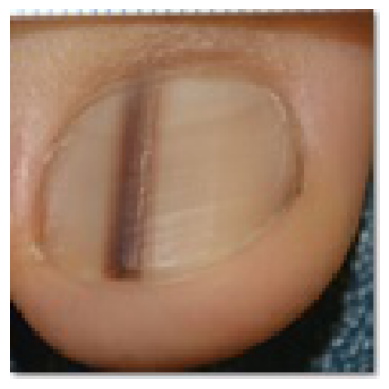

Predicted class: melanonychia
Class probabilities: [[9.9998081e-01 1.8406558e-05 2.5708187e-07 3.0265920e-07 1.8763241e-07]]
1/1 [==============================] - 0s 20ms/step


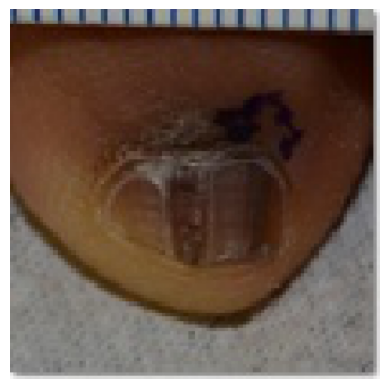

Predicted class: melanonychia
Class probabilities: [[9.9999475e-01 5.2313189e-06 3.1602618e-10 5.6871941e-11 6.2742633e-09]]
1/1 [==============================] - 0s 17ms/step


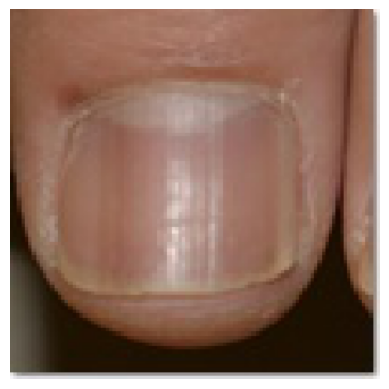

Predicted class: melanonychia
Class probabilities: [[9.9986637e-01 1.1294606e-04 1.5465119e-05 4.4377234e-06 6.6136994e-07]]
1/1 [==============================] - 0s 19ms/step


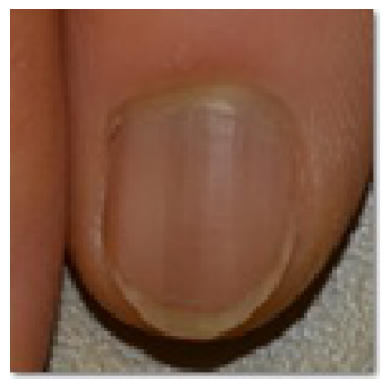

Predicted class: melanonychia
Class probabilities: [[9.9994254e-01 3.6103476e-05 1.9944451e-05 8.5502768e-07 5.6627499e-07]]
1/1 [==============================] - 0s 21ms/step


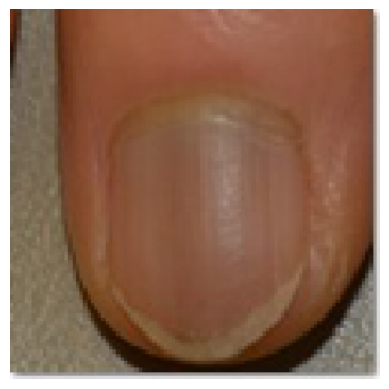

Predicted class: melanonychia
Class probabilities: [[9.9967718e-01 2.2925342e-04 6.0491686e-05 2.8472214e-05 4.5109691e-06]]
1/1 [==============================] - 0s 24ms/step


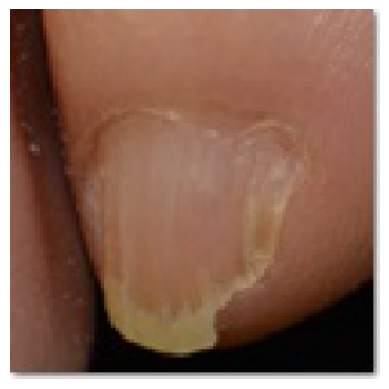

Predicted class: onychomycosis
Class probabilities: [[0.00283374 0.16204153 0.04617981 0.01392719 0.77501774]]
1/1 [==============================] - 0s 20ms/step


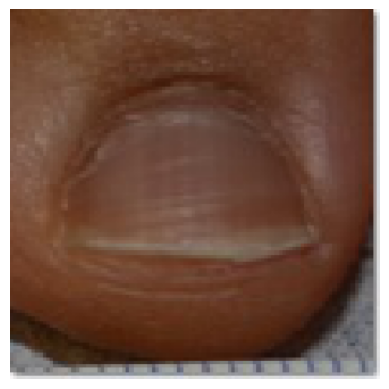

Predicted class: melanonychia
Class probabilities: [[0.78712595 0.08178868 0.04770512 0.08227399 0.00110615]]
1/1 [==============================] - 0s 20ms/step


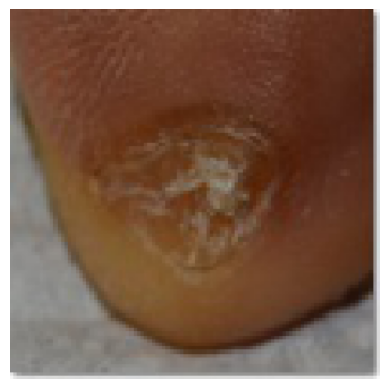

Predicted class: naildystrophy
Class probabilities: [[6.1482431e-05 9.8762321e-01 2.0685887e-03 1.8743618e-04 1.0059312e-02]]
1/1 [==============================] - 0s 20ms/step


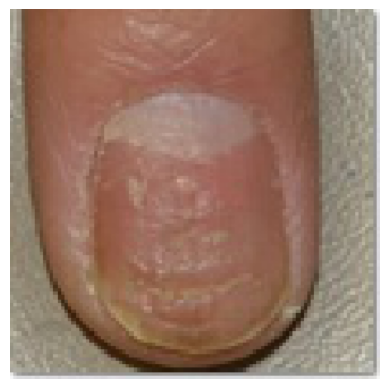

Predicted class: naildystrophy
Class probabilities: [[5.5171618e-06 9.9950314e-01 4.0785944e-05 1.8865183e-04 2.6188415e-04]]
1/1 [==============================] - 0s 23ms/step


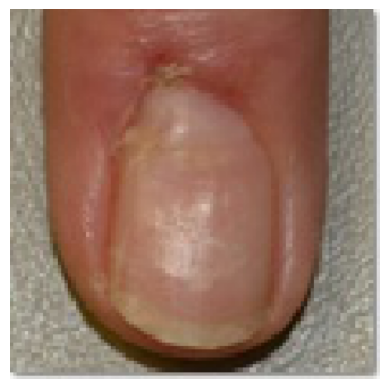

Predicted class: naildystrophy
Class probabilities: [[5.5867855e-05 9.0676266e-01 2.9398417e-03 8.8597924e-02 1.6436982e-03]]
1/1 [==============================] - 0s 17ms/step


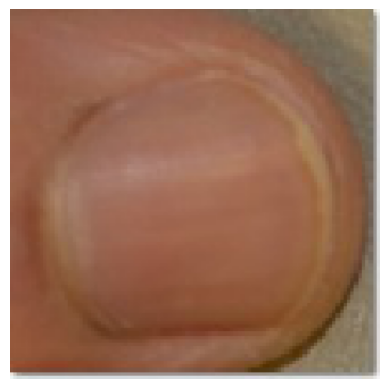

Predicted class: normalnail
Class probabilities: [[0.31294292 0.01704486 0.64501446 0.0180188  0.00697891]]
1/1 [==============================] - 0s 21ms/step


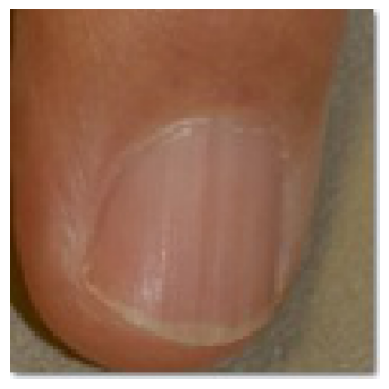

Predicted class: normalnail
Class probabilities: [[0.02185373 0.15879218 0.7782308  0.03728827 0.00383505]]
1/1 [==============================] - 0s 19ms/step


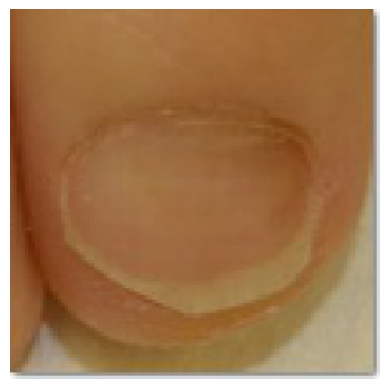

Predicted class: normalnail
Class probabilities: [[0.13009581 0.04866588 0.7332635  0.08608447 0.00189024]]
1/1 [==============================] - 0s 28ms/step


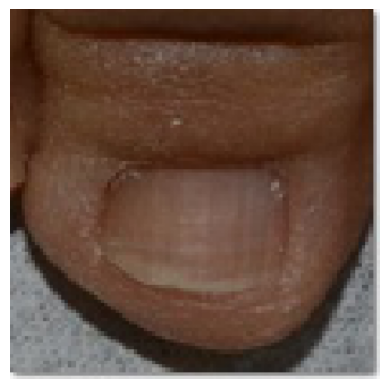

Predicted class: melanonychia
Class probabilities: [[0.9508987  0.03912495 0.00482121 0.00111061 0.00404454]]
1/1 [==============================] - 0s 19ms/step


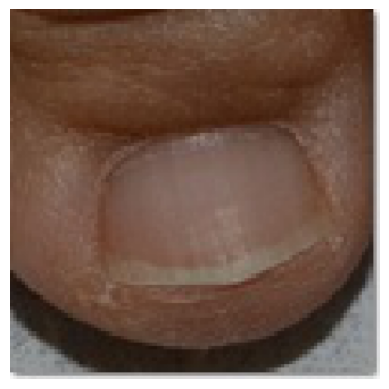

Predicted class: normalnail
Class probabilities: [[0.08119296 0.03956962 0.78364843 0.08798642 0.00760269]]
1/1 [==============================] - 0s 21ms/step


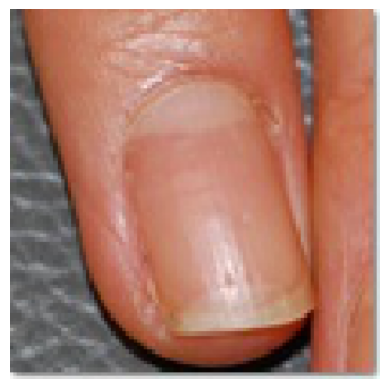

Predicted class: onycholysis
Class probabilities: [[3.9217248e-05 4.0626451e-02 1.0449744e-02 9.4843554e-01 4.4902012e-04]]
1/1 [==============================] - 0s 28ms/step


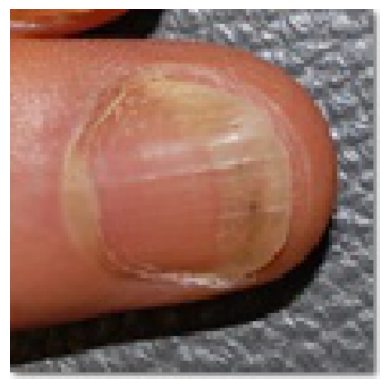

Predicted class: onycholysis
Class probabilities: [[1.0079779e-09 1.0706319e-05 2.6570461e-07 9.9984074e-01 1.4828538e-04]]
1/1 [==============================] - 0s 19ms/step


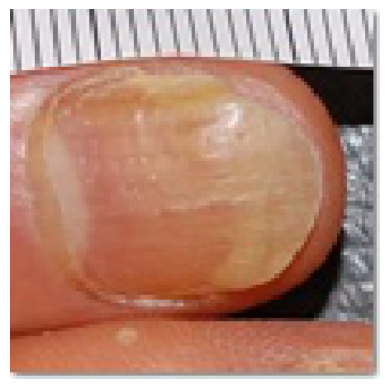

Predicted class: onycholysis
Class probabilities: [[1.5317639e-10 3.9789957e-05 2.1827645e-07 9.9993801e-01 2.1876016e-05]]
1/1 [==============================] - 0s 19ms/step


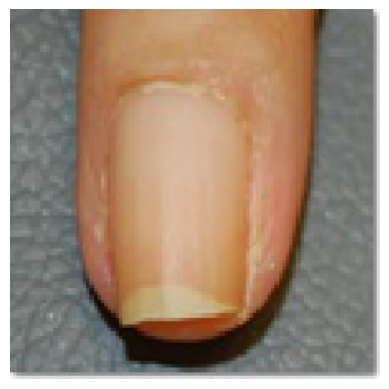

Predicted class: onycholysis
Class probabilities: [[2.5375124e-05 5.9418082e-03 2.5381213e-03 9.9075437e-01 7.4036367e-04]]
1/1 [==============================] - 0s 22ms/step


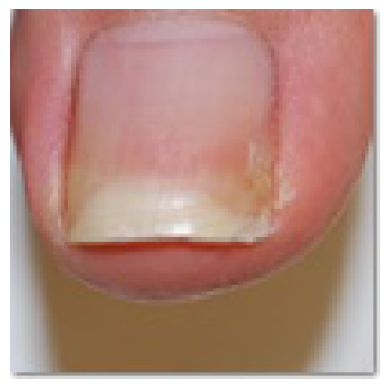

Predicted class: onycholysis
Class probabilities: [[2.8711304e-07 5.7184647e-05 6.6575967e-04 9.9927264e-01 4.1676635e-06]]
1/1 [==============================] - 0s 20ms/step


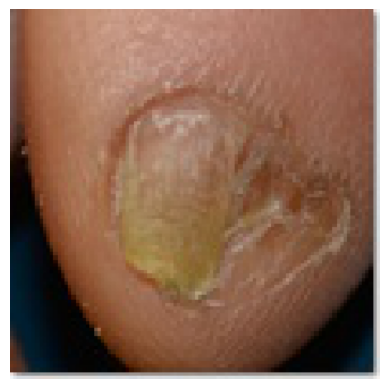

Predicted class: onychomycosis
Class probabilities: [[2.5531965e-05 7.9729244e-02 1.3762020e-04 1.5744202e-04 9.1995019e-01]]
1/1 [==============================] - 0s 30ms/step


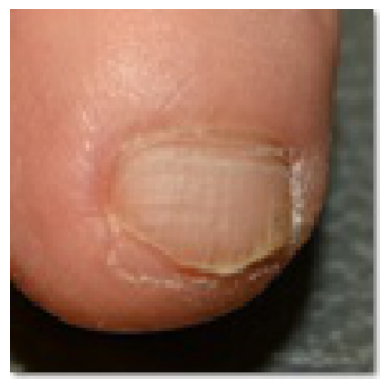

Predicted class: normalnail
Class probabilities: [[0.07028792 0.3145417  0.43725187 0.02693285 0.15098572]]
1/1 [==============================] - 0s 19ms/step


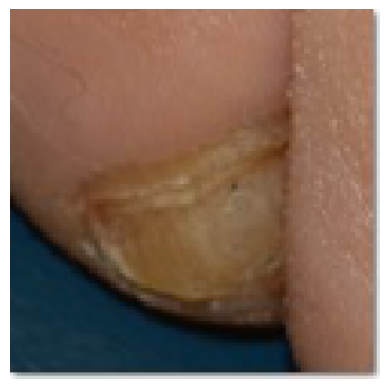

Predicted class: onychomycosis
Class probabilities: [[2.1281189e-04 1.8411523e-02 8.7484758e-04 5.6584500e-05 9.8044419e-01]]
1/1 [==============================] - 0s 20ms/step


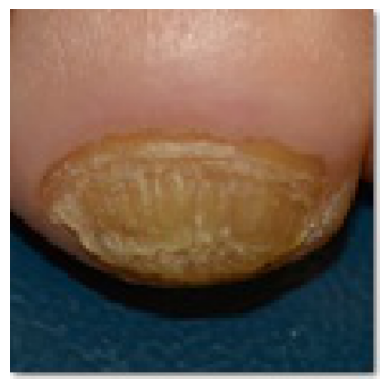

Predicted class: onychomycosis
Class probabilities: [[4.2821389e-06 3.2159367e-03 2.8125047e-05 1.8689234e-06 9.9674976e-01]]
1/1 [==============================] - 0s 19ms/step


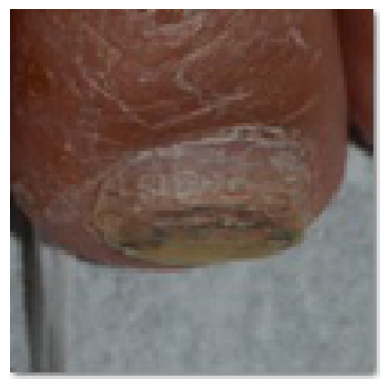

Predicted class: onychomycosis
Class probabilities: [[1.5456610e-03 1.2227489e-01 3.1602994e-04 2.8613236e-04 8.7557727e-01]]


In [22]:

for i, k in trainDs.class_indices.items():
    for j in range(1,6):
        predSingleImage(rootDir+f"test2/{i}/{i} ({j}).jpg",trainDs,model)
